In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("pastel")

from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier 

In [2]:
df = pd.read_csv("Anonymize_Loan_Default_data.csv", encoding= 'ISO-8859-1')
df.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,...,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,repay_fail
0,2,2,2,0.0,0.0,0.0,36 months,0.00,0.00,< 1 year,...,1.0,0.000000,0.00,0.00,0.00,Jan-07,0.00,Jan-07,Jan-07,1
1,3,545583,703644,2500.0,2500.0,2500.0,36 months,13.98,85.42,4 years,...,10.0,3075.291779,3075.29,2500.00,575.29,Jul-13,90.85,Aug-13,Jun-16,0
2,4,532101,687836,5000.0,5000.0,5000.0,36 months,15.95,175.67,4 years,...,15.0,2948.760000,2948.76,1909.02,873.81,Nov-11,175.67,NaN,Mar-12,1
3,5,877788,1092507,7000.0,7000.0,7000.0,36 months,9.91,225.58,10+ years,...,20.0,8082.391880,8082.39,7000.00,1082.39,Mar-14,1550.27,NaN,Mar-14,0
4,6,875406,1089981,2000.0,2000.0,2000.0,36 months,5.42,60.32,10+ years,...,15.0,2161.663244,2161.66,2000.00,161.66,Feb-14,53.12,NaN,Jun-16,0


In [3]:
df.columns

Index(['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'purpose', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'repay_fail'],
      dtype='object')

# Clean Data

In [4]:
# filter down to variables of interest
vars_of_interest = ['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment', 'home_ownership',
                    'annual_inc', 'purpose', 'dti', 'delinq_2yrs', 'inq_last_6mths',
                    'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'total_pymnt', 'total_rec_prncp',
                    'total_rec_int', 'last_credit_pull_d', 'repay_fail']

df = df[vars_of_interest]
df.head()

,loan_amnt,funded_amnt,term,int_rate,installment,home_ownership,annual_inc,purpose,dti,delinq_2yrs,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_pymnt,total_rec_prncp,total_rec_int,last_credit_pull_d,repay_fail
0,0.0,0.0,36 months,0.00,0.00,RENT,0.0,major_purchase,0.00,0.0,...,0.0,0.0,0.0,0.00%,1.0,0.000000,0.00,0.00,Jan-07,1
1,2500.0,2500.0,36 months,13.98,85.42,RENT,20004.0,other,19.86,0.0,...,7.0,0.0,981.0,21.30%,10.0,3075.291779,2500.00,575.29,Jun-16,0
2,5000.0,5000.0,36 months,15.95,175.67,RENT,59000.0,debt_consolidation,19.57,0.0,...,7.0,0.0,18773.0,99.90%,15.0,2948.760000,1909.02,873.81,Mar-12,1
3,7000.0,7000.0,36 months,9.91,225.58,MORTGAGE,53796.0,other,10.80,3.0,...,7.0,0.0,3269.0,47.20%,20.0,8082.391880,7000.00,1082.39,Mar-14,0
4,2000.0,2000.0,36 months,5.42,60.32,RENT,30000.0,debt_consolidation,3.60,0.0,...,7.0,0.0,0.0,0%,15.0,2161.663244,2000.00,161.66,Jun-16,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38480 entries, 0 to 38479
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   loan_amnt           38479 non-null  float64
 1   funded_amnt         38479 non-null  float64
 2   term                38480 non-null  object 
 3   int_rate            38480 non-null  float64
 4   installment         38479 non-null  float64
 5   home_ownership      38480 non-null  object 
 6   annual_inc          38478 non-null  float64
 7   purpose             38480 non-null  object 
 8   dti                 38480 non-null  float64
 9   delinq_2yrs         38479 non-null  float64
 10  inq_last_6mths      38479 non-null  float64
 11  open_acc            38479 non-null  float64
 12  pub_rec             38479 non-null  float64
 13  revol_bal           38476 non-null  float64
 14  revol_util          38421 non-null  object 
 15  total_acc           38479 non-null  float64
 16  tota

In [6]:
df.isna().sum()

loan_amnt              1
funded_amnt            1
term                   0
int_rate               0
installment            1
home_ownership         0
annual_inc             2
purpose                0
dti                    0
delinq_2yrs            1
inq_last_6mths         1
open_acc               1
pub_rec                1
revol_bal              4
revol_util            59
total_acc              1
total_pymnt            1
total_rec_prncp        1
total_rec_int          1
last_credit_pull_d     3
repay_fail             0
dtype: int64

In [7]:
# since we have such a large dataset, we're going to just drop the missing values for simplicity
df.dropna(inplace = True)
df.shape

(38413, 21)

In [8]:
df.isna().sum()

loan_amnt             0
funded_amnt           0
term                  0
int_rate              0
installment           0
home_ownership        0
annual_inc            0
purpose               0
dti                   0
delinq_2yrs           0
inq_last_6mths        0
open_acc              0
pub_rec               0
revol_bal             0
revol_util            0
total_acc             0
total_pymnt           0
total_rec_prncp       0
total_rec_int         0
last_credit_pull_d    0
repay_fail            0
dtype: int64

In [9]:
group = df.groupby('repay_fail').mean(numeric_only = True)
group

,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,total_pymnt,total_rec_prncp,total_rec_int
repay_fail,,,,,,,,,,,,,,,
0,10970.550666,10720.917929,11.843420,321.546767,70048.956978,13.259909,0.147550,1.011256,9.360915,0.052628,14122.172852,22.223824,12932.069105,10677.791932,2253.282401
1,11860.349578,11520.518340,13.918936,333.986062,63306.090458,14.057026,0.176683,1.490615,9.295678,0.087825,15325.250387,21.585156,6718.584980,3920.634789,2132.016396


In [10]:
np.round(df.repay_fail.mean(), 2) * 100 # failure rate of the average loan

15.0

In [11]:
df.groupby('purpose').aggregate({'repay_fail': 'mean', 'loan_amnt': 'count'})

,repay_fail,loan_amnt
purpose,,
car,0.109682,1477
credit_card,0.115694,4970
debt_consolidation,0.155028,17900
educational,0.214099,383
home_improvement,0.131652,2894
house,0.160622,386
major_purchase,0.104730,2072
medical,0.172363,673
moving,0.164580,559


# Exploratory Analysis

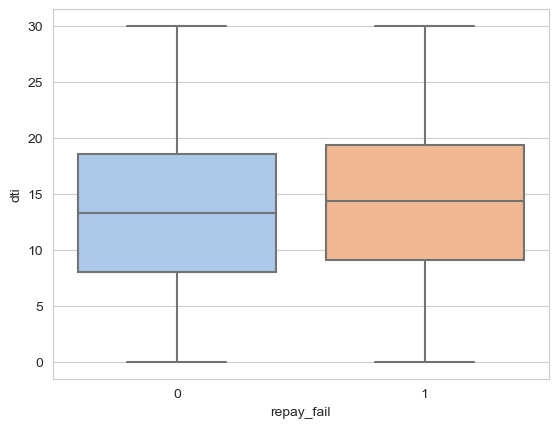

In [12]:
plt.figure()
sns.boxplot(data = df, x = 'repay_fail', y = 'dti')
plt.show()

<AxesSubplot:xlabel='repay_fail', ylabel='delinq_2yrs'>

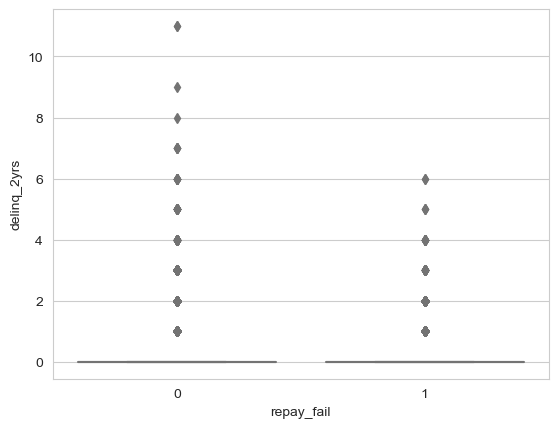

In [13]:
plt.figure()
sns.boxplot(data = df, x = 'repay_fail', y = 'delinq_2yrs')

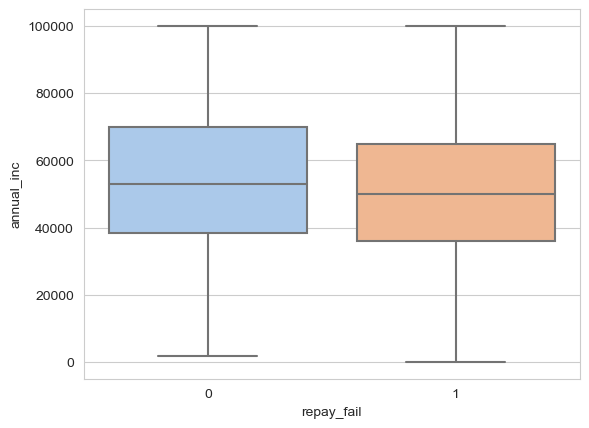

In [14]:
plt.figure()
sns.boxplot(data = df[df.annual_inc < 100_000], x = 'repay_fail', y = 'annual_inc' )
plt.show()

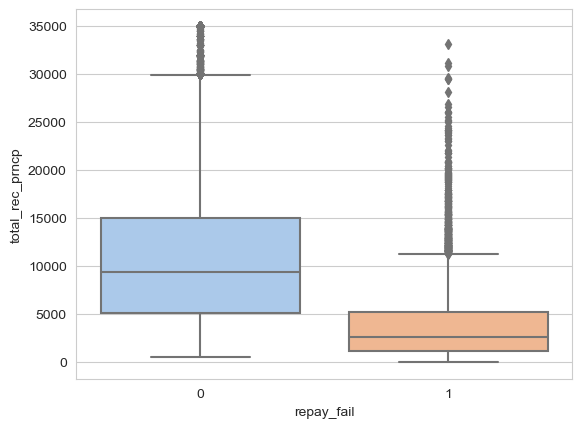

In [15]:
plt.figure()
sns.boxplot(data = df, x = 'repay_fail', y = 'total_rec_prncp')
plt.show()

# Categorical Variable Exploration

It seems that the purpose of the loan seems to be a reliable predictor of whether or not the payer defaults.  Small Businesses fail more often than loans for any other purpose.  We will add this

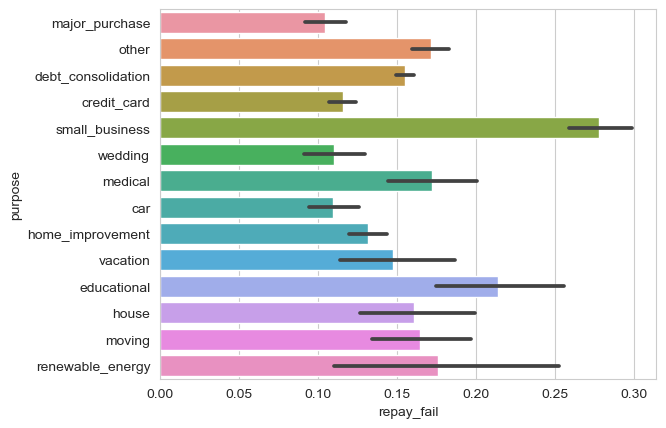

In [16]:
sns.barplot(data = df, x = 'repay_fail', y = 'purpose')
plt.show()

# Statistical Tests on Continous Variables

In [17]:
def perm_fun(df, col, len_a):
    a = df.sample(n = len_a, replace = False)
    b = df[~df.index.isin(a.index)]
    
    return a[col].mean() - b[col].mean()

In [18]:
def generate_diffs_and_graph(col, len_a, df):
    # generated permuted differences
    actual_diff = group.loc[1][col] - group.loc[0][col]
    diffs = [perm_fun(df, col, len_a) for _ in range(1000)]
    
    # plot permuted differences and actual difference
    plt.figure(figsize = (5,4))
    sns.histplot(diffs)
    plt.axvline(x = actual_diff, color = 'red')
    plt.title(f"Perm Test (statistical significance) for {col}")
    plt.show()

    # calculate and print p-val for statistical significance test
    p_val = [np.abs(diff) > np.abs(actual_diff) for diff in diffs]
    p_val = np.array(p_val).mean()
    print("p-val:", p_val)
    
    return p_val

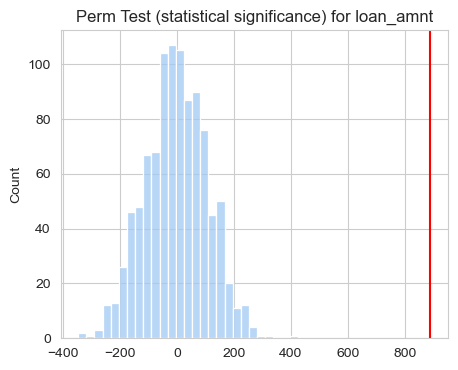

p-val: 0.0


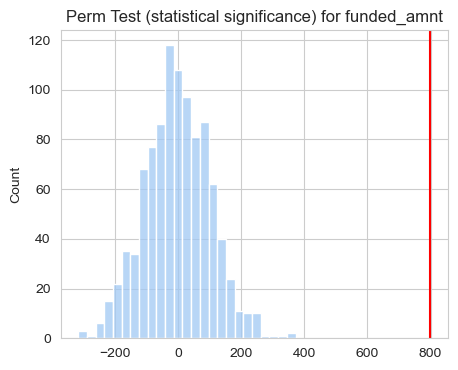

p-val: 0.0


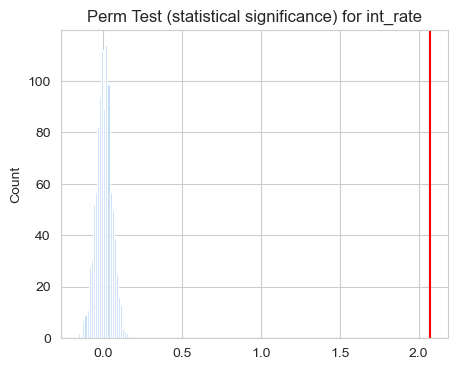

p-val: 0.0


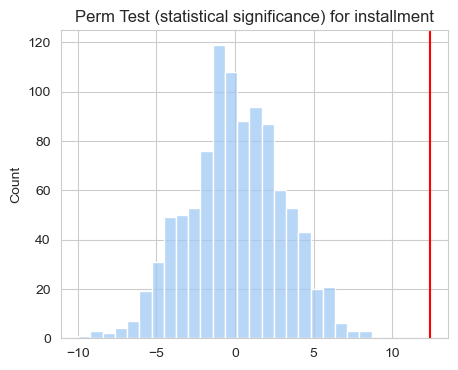

p-val: 0.0


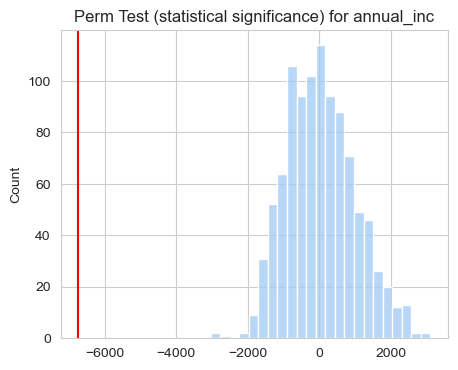

p-val: 0.0


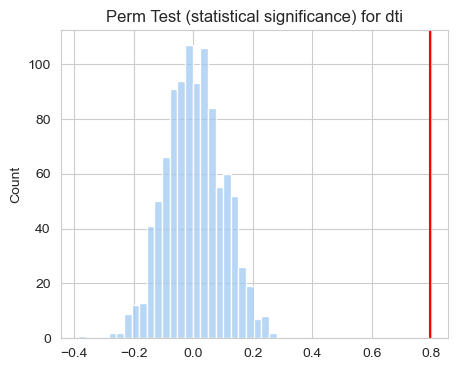

p-val: 0.0


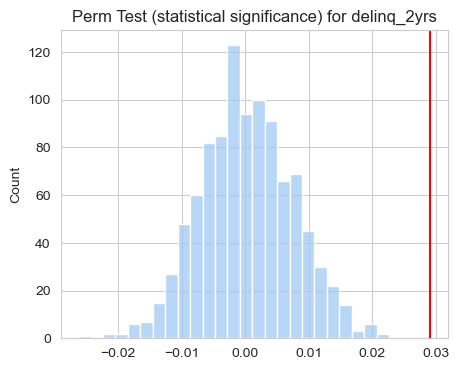

p-val: 0.0


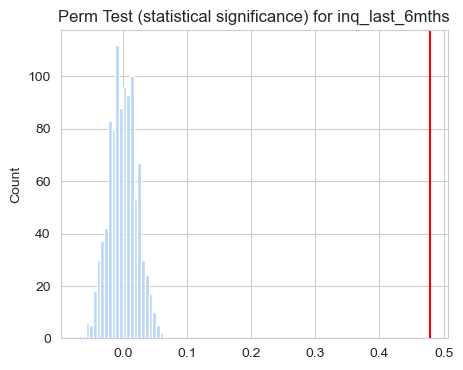

p-val: 0.0


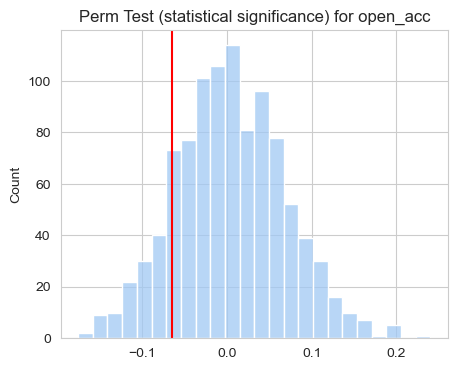

p-val: 0.303


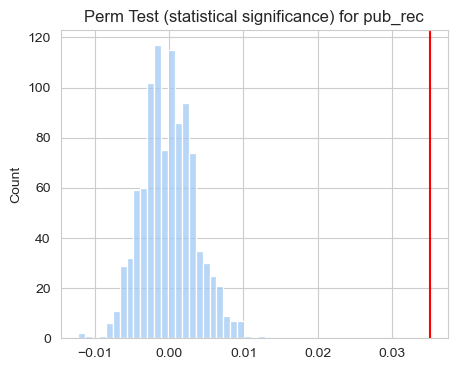

p-val: 0.0


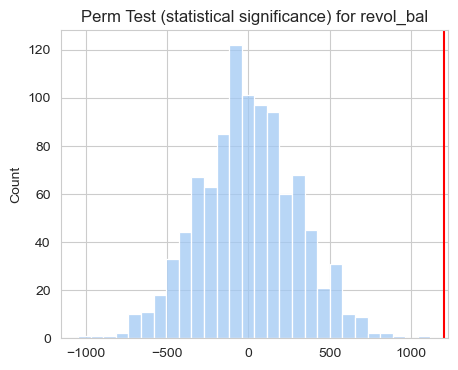

p-val: 0.0


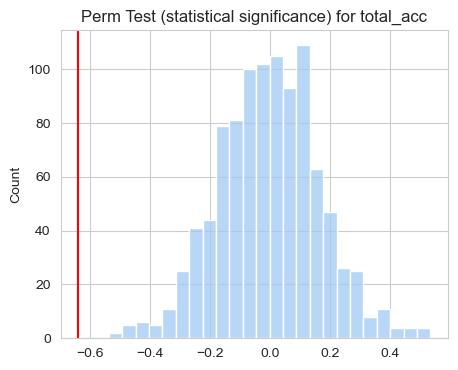

p-val: 0.0


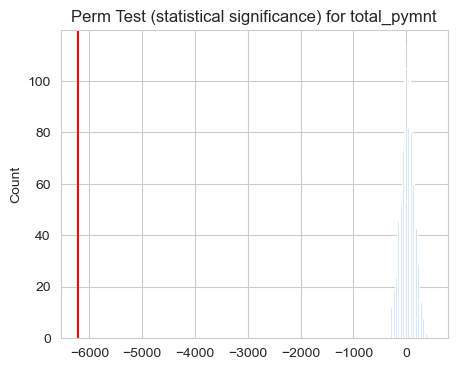

p-val: 0.0


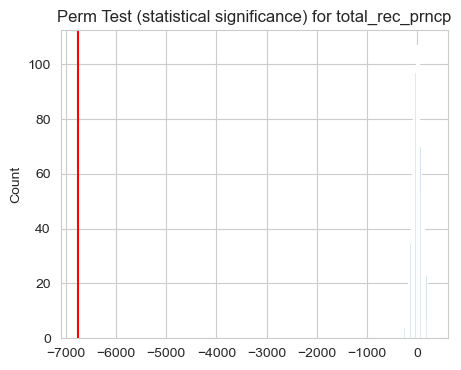

p-val: 0.0


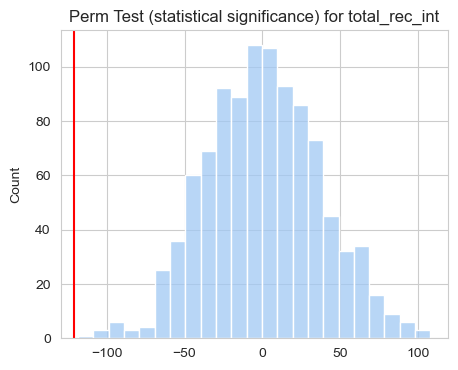

p-val: 0.0


In [19]:
significant_vars = []
len_a = df.repay_fail.value_counts().loc[1]

for col in group.columns:
    p_val = generate_diffs_and_graph(col, len_a, df)
    if (p_val <= .05):
        significant_vars.append(col)

In [20]:
significant_vars

['loan_amnt',
 'funded_amnt',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'pub_rec',
 'revol_bal',
 'total_acc',
 'total_pymnt',
 'total_rec_prncp',
 'total_rec_int']

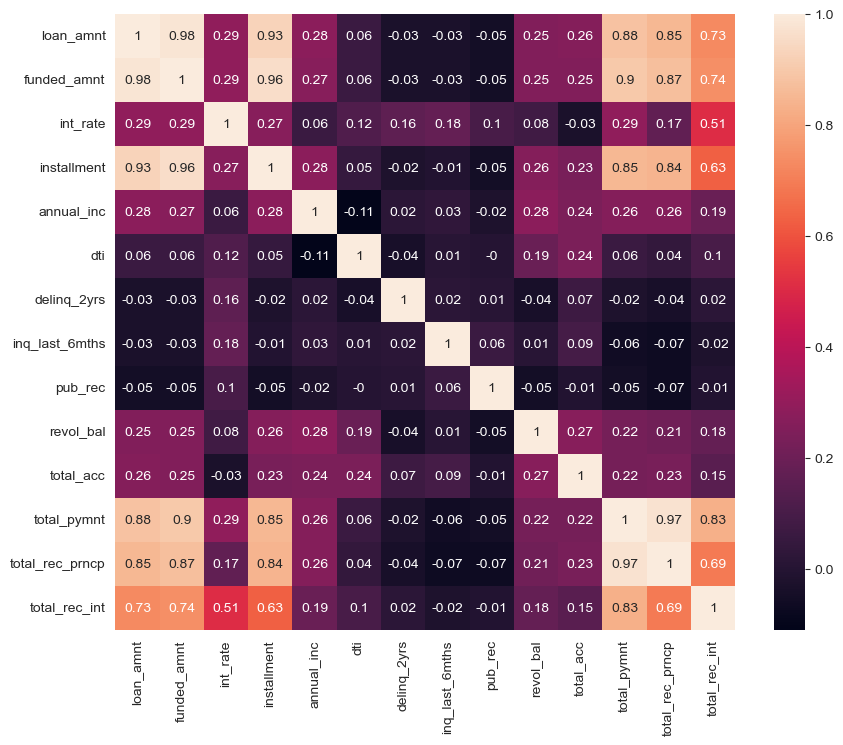

In [21]:
plt.figure(figsize = (10,8))
sns.heatmap(df[significant_vars].corr().round(2), annot = True)
plt.show()

Since funded amount is highly correlated with loan_amnt, funded_amnt, installment, total_paymnt, total_rec_prncp, and total_rec_int, we just includ the funded amount variable in our ML algorithm.

# Pipeline to Create Dataset for ML Algorithm

In [22]:
num_features = ['funded_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'pub_rec', 'total_acc']
loan_num = df[num_features]

num_pipeline = Pipeline([
    ('imputer', SimpleImputer())
])
loan_num_tr = num_pipeline.fit_transform(loan_num)
loan_num_tr

array([[0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00],
       [2.5000e+03, 1.3980e+01, 2.0004e+04, ..., 5.0000e+00, 0.0000e+00,
        1.0000e+01],
       [5.0000e+03, 1.5950e+01, 5.9000e+04, ..., 1.0000e+00, 0.0000e+00,
        1.5000e+01],
       ...,
       [1.0550e+04, 1.4960e+01, 9.5088e+04, ..., 1.0000e+00, 1.0000e+00,
        2.5000e+01],
       [1.0000e+04, 1.6890e+01, 4.8720e+04, ..., 2.0000e+00, 0.0000e+00,
        1.2000e+01],
       [3.2000e+03, 1.3490e+01, 3.8400e+04, ..., 2.0000e+00, 1.0000e+00,
        1.8000e+01]])

In [23]:
loan_cat = df[['purpose']]

cat_pipeline = Pipeline([
    ('categorical encoder', OneHotEncoder()) # get one hot values
])

loan_cat_tr = cat_pipeline.fit_transform(loan_cat)
loan_cat_tr = loan_cat_tr.toarray()
loan_cat_tr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [24]:
num_columns = num_features
loan_columns = ['purpose']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_columns),
    ('cat', cat_pipeline, loan_columns)
])

loan_prepared = full_pipeline.fit_transform(df)
loan_prepared

array([[0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.5000e+03, 1.3980e+01, 2.0004e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [5.0000e+03, 1.5950e+01, 5.9000e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [1.0550e+04, 1.4960e+01, 9.5088e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0000e+04, 1.6890e+01, 4.8720e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [3.2000e+03, 1.3490e+01, 3.8400e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

In [25]:
print(loan_prepared.shape)
print(df['repay_fail'].shape)

(38413, 22)
(38413,)


# Machine Learning Algorithm

In [26]:
num_features = ['funded_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'pub_rec', 'total_acc']
target = 'repay_fail'


X = loan_prepared
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8)

In [27]:
# create model
model = XGBClassifier(n_estimators = 100, max_depth = 10)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [28]:
# perform grid search to tune hyperparameters
params = {
    "n_estimators": [50, 100, 200],
    "max_depth": [4, 6, 8]
}

xgb = XGBClassifier()

grid = GridSearchCV(xgb, param_grid = params)
grid.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_c

In [29]:
grid.best_params_

{'max_depth': 4, 'n_estimators': 50}

In [30]:
# retrain model with the hypertuned parameters
model = XGBClassifier(n_estimators = grid.best_params_["max_depth"], max_depth = grid.best_params_["n_estimators"])
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=50, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=4, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [32]:
# see how important each feature is
list(zip(num_features, model.feature_importances_))

[('funded_amnt', 0.043353677),
 ('int_rate', 0.07612682),
 ('annual_inc', 0.04788081),
 ('dti', 0.04664425),
 ('delinq_2yrs', 0.038857747),
 ('inq_last_6mths', 0.058790635),
 ('pub_rec', 0.048030797),
 ('total_acc', 0.041050218)]

In [38]:
predictions = model.predict(X_test)

# get model metrics
print(np.round(accuracy_score(y_test, predictions), 2) * 100)
print(np.round(precision_score(y_test, predictions), 2) * 100)
print(np.round(recall_score(y_test, predictions), 2) * 100)

83.0
33.0
8.0
